#1. 계산 그래프를 통한 오차역전파법 이해하기

### 1.1 단순한 계층 구현하기

1.1.1 곱셈 계층

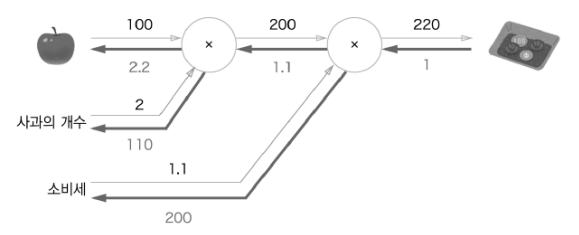

In [ ]:
class MulLayer:
  def __init__(self):
    self.x = None
    self.y = None

  def forward(self, x, y):
    self.x = x
    self.y = y
    out = x*y

    return out

  def backward(self, dout):
    dx = dout * self.y
    dy = dout * self.x

    return dx, dy

(1) 순전파

In [ ]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


(2) 역전파

In [ ]:
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


1.1.2 덧셈 계층

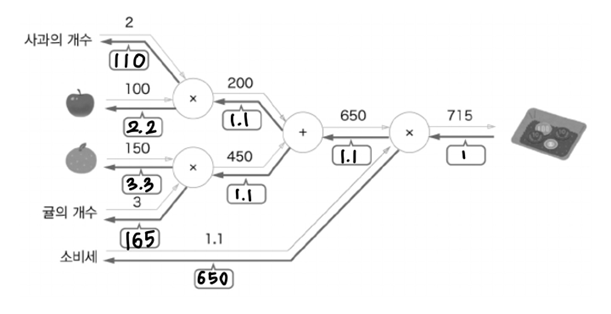

In [ ]:
class AddLayer:
  def __init__(self):
    pass

  def forward(self, x, y):
    out = x + y
    return out

  def backward(self, dout):
    dx = dout * 1
    dy = dout * 1
    return dx, dy


(1) 순전파

In [ ]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

print(apple_price, orange_price, all_price, price)

200 450 650 715.0000000000001


(2) 역전파

In [ ]:
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)

print(dapple_num, dapple, dorange, dorange_num, dtax)

110.00000000000001 2.2 3.3000000000000003 165.0 650


1.1.3 배치용 Affine 계층

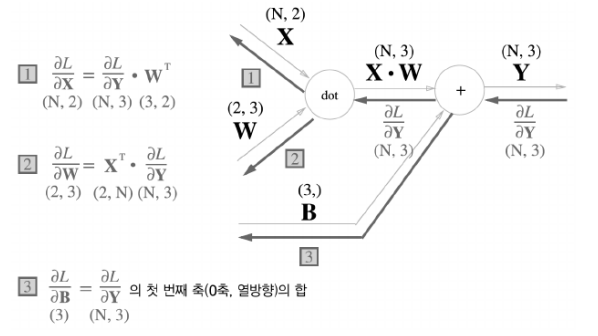

In [ ]:
import numpy as np

In [ ]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dx = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)

    return dx

1.1.4 ReLU 계층 구현하기

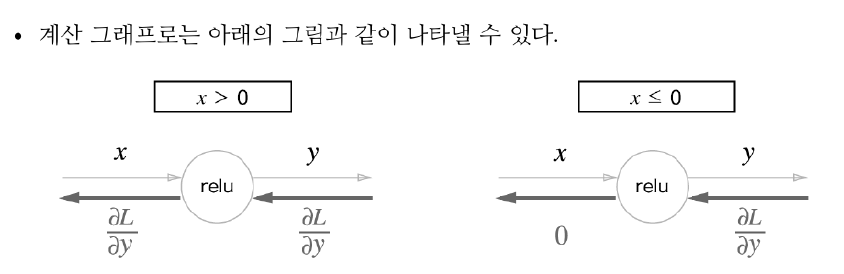

In [ ]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x<=0)
    out = x.copy()
    out[self.mask] = 0 #x<=0이하인 경우

    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx

1.1.5 Sigmoid 계층 구현하기

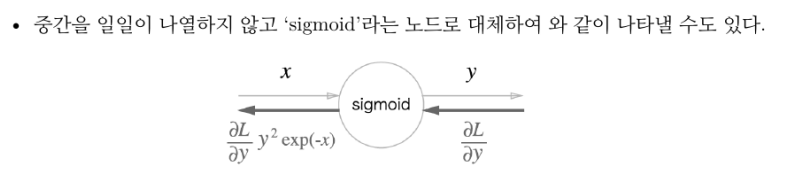

In [ ]:
class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1/ (1+np.exp(-x))
    self.out = out

    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out

    return dx

1.1.6 Softmax 계층 구현하기

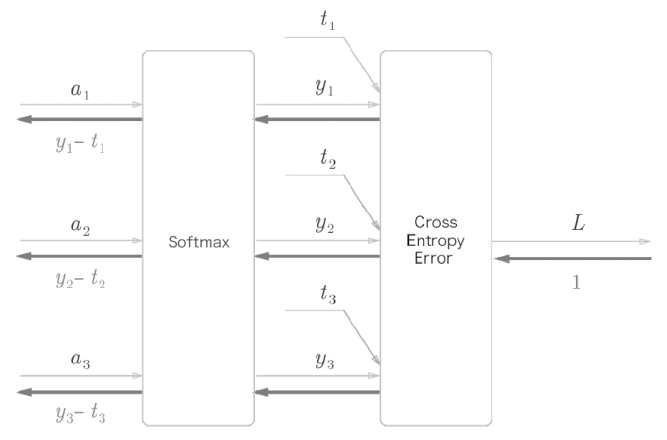

In [ ]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)  # 오버플로 대책
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a

    return y


def cross_entropy_error(y, t):
    delta = 1e-7  # 0일때 -무한대가 되지 않기 위해 작은 값을 더함
    return -np.sum(t * np.log(y + delta))


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None  # 손실
        self.y = None     # softmax의 출력
        self.t = None     # 정답 레이블(원-핫 벡터)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)  # 3.5.2, 4.2.2에서 구현
        self.loss = cross_entropy_error(self.y,self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = self.y -self.t /batch_size

        return dx

## 1.2 오차역전파법을 적용한 인공신경망 구현하기

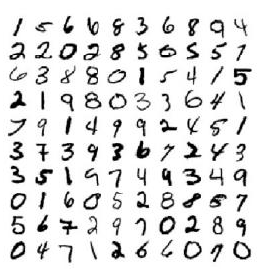

- 인공신경망 모형도

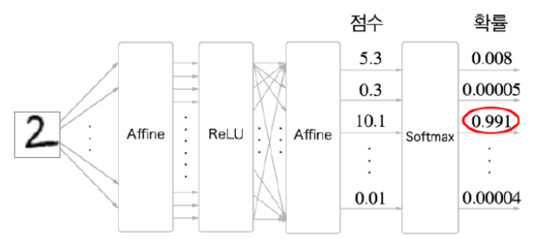

MNIST 데이터를 이용하여, 손글씨 이미지를 보고 알맞은 숫자를 분류하는 인공신경망을 구현해볼 계획이다.

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
# from common.layers import *
# from common.gradient import numerical_gradient
from collections import OrderedDict

* 오차 역전파와 비교를 위한 수치 미분 정의

In [ ]:
#수치 미분과 계산 그래프 방식 두가지 모두 해보고 비교해보기
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val
        fxh2 = f(x) # f(x)
        grad[idx] = (fxh1 - fxh2) / (h)

        x[idx] = tmp_val # 값 복원
        it.iternext()

    return grad

* Two Layers 인공신경망 Class 정의

In [ ]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std* np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y,t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse() ### 역전파 해야되서 리버스
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW , self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW , self.layers['Affine2'].db

        return grads

* MNIST 데이터로 학습하여 수치 미분한 결과와 비교하기

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from dataset.mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 절대 오차의 평균을 구한다.
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:0.0008569877868070908
b1:0.004249354184452707
W2:0.009217074894887432
b2:0.27991236796335134


* Train과 Test Accuray 확인

In [ ]:
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)

    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("##### Epoch {0}: Train epoch {1:.2f} Test epoch {2:.2f} #####".format(int(i/600), train_acc, test_acc))

##### Epoch 0: Train epoch 0.08 Test epoch 0.08 #####
##### Epoch 1: Train epoch 0.91 Test epoch 0.91 #####
##### Epoch 2: Train epoch 0.92 Test epoch 0.92 #####
##### Epoch 3: Train epoch 0.94 Test epoch 0.94 #####
##### Epoch 4: Train epoch 0.94 Test epoch 0.94 #####
##### Epoch 5: Train epoch 0.95 Test epoch 0.95 #####
##### Epoch 6: Train epoch 0.95 Test epoch 0.95 #####
##### Epoch 7: Train epoch 0.96 Test epoch 0.95 #####
##### Epoch 8: Train epoch 0.96 Test epoch 0.96 #####
##### Epoch 9: Train epoch 0.96 Test epoch 0.96 #####
##### Epoch 10: Train epoch 0.96 Test epoch 0.96 #####
##### Epoch 11: Train epoch 0.97 Test epoch 0.96 #####
##### Epoch 12: Train epoch 0.97 Test epoch 0.96 #####
##### Epoch 13: Train epoch 0.97 Test epoch 0.96 #####
##### Epoch 14: Train epoch 0.97 Test epoch 0.96 #####
##### Epoch 15: Train epoch 0.97 Test epoch 0.97 #####
##### Epoch 16: Train epoch 0.97 Test epoch 0.97 #####
